Adapted from 241028_midterm_figures

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/glade/u/home/jjeffree/ensemble-analogue-predictability/')
import predictability_tools as pt

In [4]:
plt.figure()
plt.rcParams['font.size'] = 24


<Figure size 640x480 with 0 Axes>

In [10]:
client.close()

2025-02-04 14:18:43,801 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-04 14:18:43,802 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-04 14:18:43,803 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-04 14:18:43,804 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


In [5]:
from dask.distributed import Client
client = Client(threads_per_worker=1,memory_limit=0)
client

/glade/work/jjeffree/conda-envs/jj_default2/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38929 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/38929/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/38929/status,Workers: 4
Total threads: 4,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36527,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/38929/status,Total threads: 4
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45829,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/36529/status,Memory: 0 B
Nanny: tcp://127.0.0.1:38741,


In [6]:
models = ['EC-Earth3_tos_nomean','GFDL-CM2-1','CESM1_pi']
models.sort()

In [7]:
models

['CESM1_pi', 'EC-Earth3_tos_nomean', 'GFDL-CM2-1']

In [16]:
for m in ("10P","10-30P","30-10P","10P30A","10P30I","10P30N","10P30S"):
    r={}
    for i in range(len(models)):
        model_name = models[i]
        if model_name == 'EC-Earth3_tos_nomean':
            tos_zos = 'tos'
        else:
            tos_zos = 'tos_zos'
        fct = xr.open_mfdataset('/glade/work/jjeffree/results/area_corr/multiindex/'+model_name+'_'+tos_zos+'/'+m+'_*.nc').sel(index_lon='nino34')
        assert fct.mask.shape == (1,)
        r[model_name] = xr.corr(fct.verification,fct.forecast,('Y','pred_SMILE_M','lib_mi')).load()
        fct.close()
        print(model_name)
    xr.Dataset(r).to_netcdf('/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/pacemaker_'+m+'.nc')
    print(m)

CESM1_pi
EC-Earth3_tos_nomean
GFDL-CM2-1
10P
CESM1_pi
EC-Earth3_tos_nomean
GFDL-CM2-1
10-30P
CESM1_pi
EC-Earth3_tos_nomean
GFDL-CM2-1
30-10P
CESM1_pi
EC-Earth3_tos_nomean
GFDL-CM2-1
10P30A
CESM1_pi
EC-Earth3_tos_nomean
GFDL-CM2-1
10P30I
CESM1_pi
EC-Earth3_tos_nomean
GFDL-CM2-1
10P30N
CESM1_pi
EC-Earth3_tos_nomean
GFDL-CM2-1
10P30S


In [10]:
def incremental_sailboat2(skill,
                    N = 40*90*7,
                    start_mask = ('30P','30P','30P'),
                    later_mask=('30P30A','30P30I','60P'),
                    skill_type='corr',
                    vlim=(-0.075,0.075),
             fig = None,
             axs = None,
             cb_axs=None,

    ):
    assert not(0 in skill.init_month), 'Month should have coordinates'
    if skill_type=='corr':
        diff_func = lambda x,y: y**2-x**2
        cmap = 'BrBG'
        def stat_sig(r,r1):
            S = np.sqrt(1/(N-3))

            z = (np.arctanh(r1)-np.arctanh(r))/S
            
            # stat_sig = xr.ones_like(z).where(np.abs(z)>1.96)
            # if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
            #     pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':0.8,'linestyle':'dotted'}) #I think xshift is 1st month???

            stat_sig = xr.ones_like(z).where(np.abs(z)>2.58)
            if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
                pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':1,}) #I think xshift is 1st month???
        clabel0 = 'r'
        clabel = r'$\Delta$r$^2$'

    elif skill_type=='mse':
        diff_func = lambda x,y: ((y-x)/x)*100
        cmap = 'BrBG_r'

        def stat_sig(r,r1):
                F = r1/r

                p_good = scipy.stats.f.cdf(r1/r,N-2,N-2)
                p_bad = scipy.stats.f.cdf(r/r1,N-2,N-2)
                p = np.min((p_good,p_bad),axis=0)
                
                stat_sig = xr.ones_like(F).where(p<0.01)
                if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
                    pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':0.8,})#'linestyle':'dotted' #I think xshift is 1st month???

        clabel0 = 'MSE'
        clabel = '% MSE change'
    elif skill_type=='first_only':
        diff_func = lambda x,y: x**2
        cmap = 'BuGn'

        def stat_sig(r,r1):
            return None
        clabel0 = 'r'
        clabel = r'$\Delta$r$^2$'
    else:
        assert False, 'need a skill type'

    if fig is None:
        assert axs is None, 'Either pass both axs and fig or neither'
        fig, axs = plt.subplots(1,len(later_mask)+1,figsize=((len(later_mask)+1)*4,8),
                               sharex=True,sharey=True)
    elif axs is None:
        assert False, 'Either pass both axs and fig or neither'
        
    # if cb_axs is None:
    #     cb_axs=axs

    assert len(later_mask) == len(start_mask), 'later and start mask must be paired'
    for ax_i in range(len(later_mask)):
        plt.sca(axs)

        r = skill.sel(mask=start_mask[ax_i])
        r1 = skill.sel(mask=later_mask[ax_i])

        scatter = plt.pcolormesh(((r.init_month+r.L*0-5)%12+5).roll(init_month=-4),
            (r.init_month*0+r.L).roll(init_month=-4),
            diff_func(r,r1).roll(init_month=-4),
            cmap=cmap,
                                 #marker='s',s=100,
                                 vmin=vlim[0],vmax=vlim[1])
        stat_sig(r,r1)

        #plt.xticks((13,7,),('Jan','Jul',),size=32)
        #plt.title(start_mask[ax_i]+' -> '+later_mask[ax_i])
        
        axs.yaxis.set_tick_params(size=30,width=2,color='grey')
        axs.xaxis.set_tick_params(size=15,width=2,color='grey')

    if not(cb_axs is None):
        cbar = fig.colorbar(scatter, 
                            ax=cb_axs,
                            orientation='horizontal', 
                            fraction=1,
                             extend='both',
                            pad=0.1,
                            aspect=45*len(later_mask),
                           )
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(clabel, fontsize=20)

    return axs

In [35]:
def plot_bunch_of_models(r,start_mask,later_mask,models,fig=None,axs=None,add_colorbar=True, **kwargs):
    n=len(models)
    if fig == None:
        assert axs is None, "either pass both fig and axs or neither"
        fig, axs = plt.subplots(len(start_mask)+1,n,figsize=(n*4,8.2*len(start_mask)*2.2*0.8),
                                sharey=True,gridspec_kw={'height_ratios':[1]*len(start_mask)+[0.2]} #sharex='col' #was hiding xticks
                               )
    else:
        assert not(axs is None), "either pass both fig and axs or neither"
        plt.sca(axs[0,0])
    plt.subplots_adjust(wspace=0.15)

    for mi in range(len(start_mask)):
        for i,model_name in enumerate(models):
            axs[len(start_mask),i].axis('off')
            if (i==0) and (mi==0) and add_colorbar:
                cb_axs=axs[len(start_mask),:]
            else:
                cb_axs=None#(phantom_ax,phantom_ax)
            incremental_sailboat2(r[model_name],N=91*pt.n_ensemble_members[model_name]*((pt.n_ensemble_members[model_name])//5-1),
                             start_mask=[start_mask[mi]],
                             later_mask=[later_mask[mi]],
                             fig=fig,axs=axs[mi,i],cb_axs=cb_axs,**kwargs)
    
            axs[mi,0].set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)
            axs[mi,-1].tick_params(right=True,labelright=True)
            axs[mi,-1].set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)
            
            # old_title = axs[0,i+1].get_title()
            if model_name == 'CESM2-LE':
                axs[mi,i].set_title('CESM2',size=24,pad=20)
            else:
                axs[mi,i].set_title(model_name,size=24,pad=20)
            axs[mi,0].set_ylabel('Lead time (months)',size=24)
            axs[mi,-1].set_ylabel('Lead time (months)',size=24)
            axs[mi,-1].yaxis.set_label_position("right")

            
            axs[mi,i].set_xticks([7,10,13,16],['','','',''],size=20,rotation=45)
            axs[-2,i].set_xticks([7,10,13,16],['Jul','Oct','Jan','Apr'],size=20,rotation=45)
            axs[-2,i].set_xlabel('initialisation',size=20)

            for inc in (0,12,24,):
                axs[mi,i].plot((4.5,16.5),np.array((11.5,-0.5))+inc,c='#666666',linestyle =(0, (7, 10)))
    return fig, axs

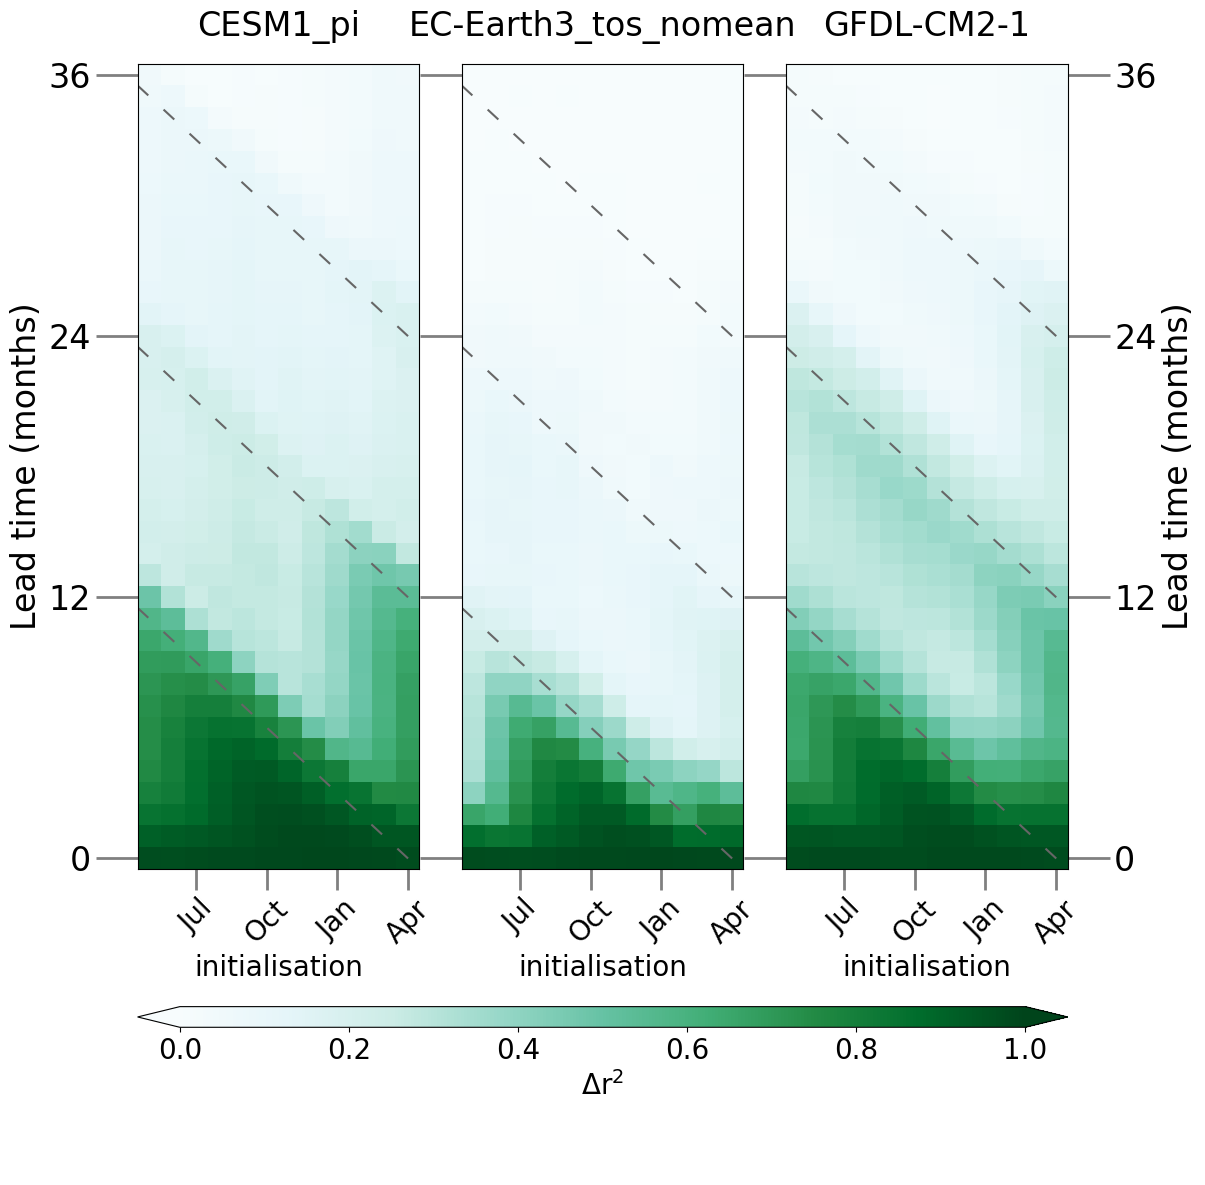

In [40]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/pacemaker_'+m+'.nc' 
                       for m in ('10P',)]).load()
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P',),
                     later_mask = ('10P',),
                     skill_type='first_only',
                     vlim=(0,1),
                     models=models)
plt.subplots_adjust(hspace=0.3)

plt.savefig('figures/area_corr_weight/pacemaker_baseline.pdf')

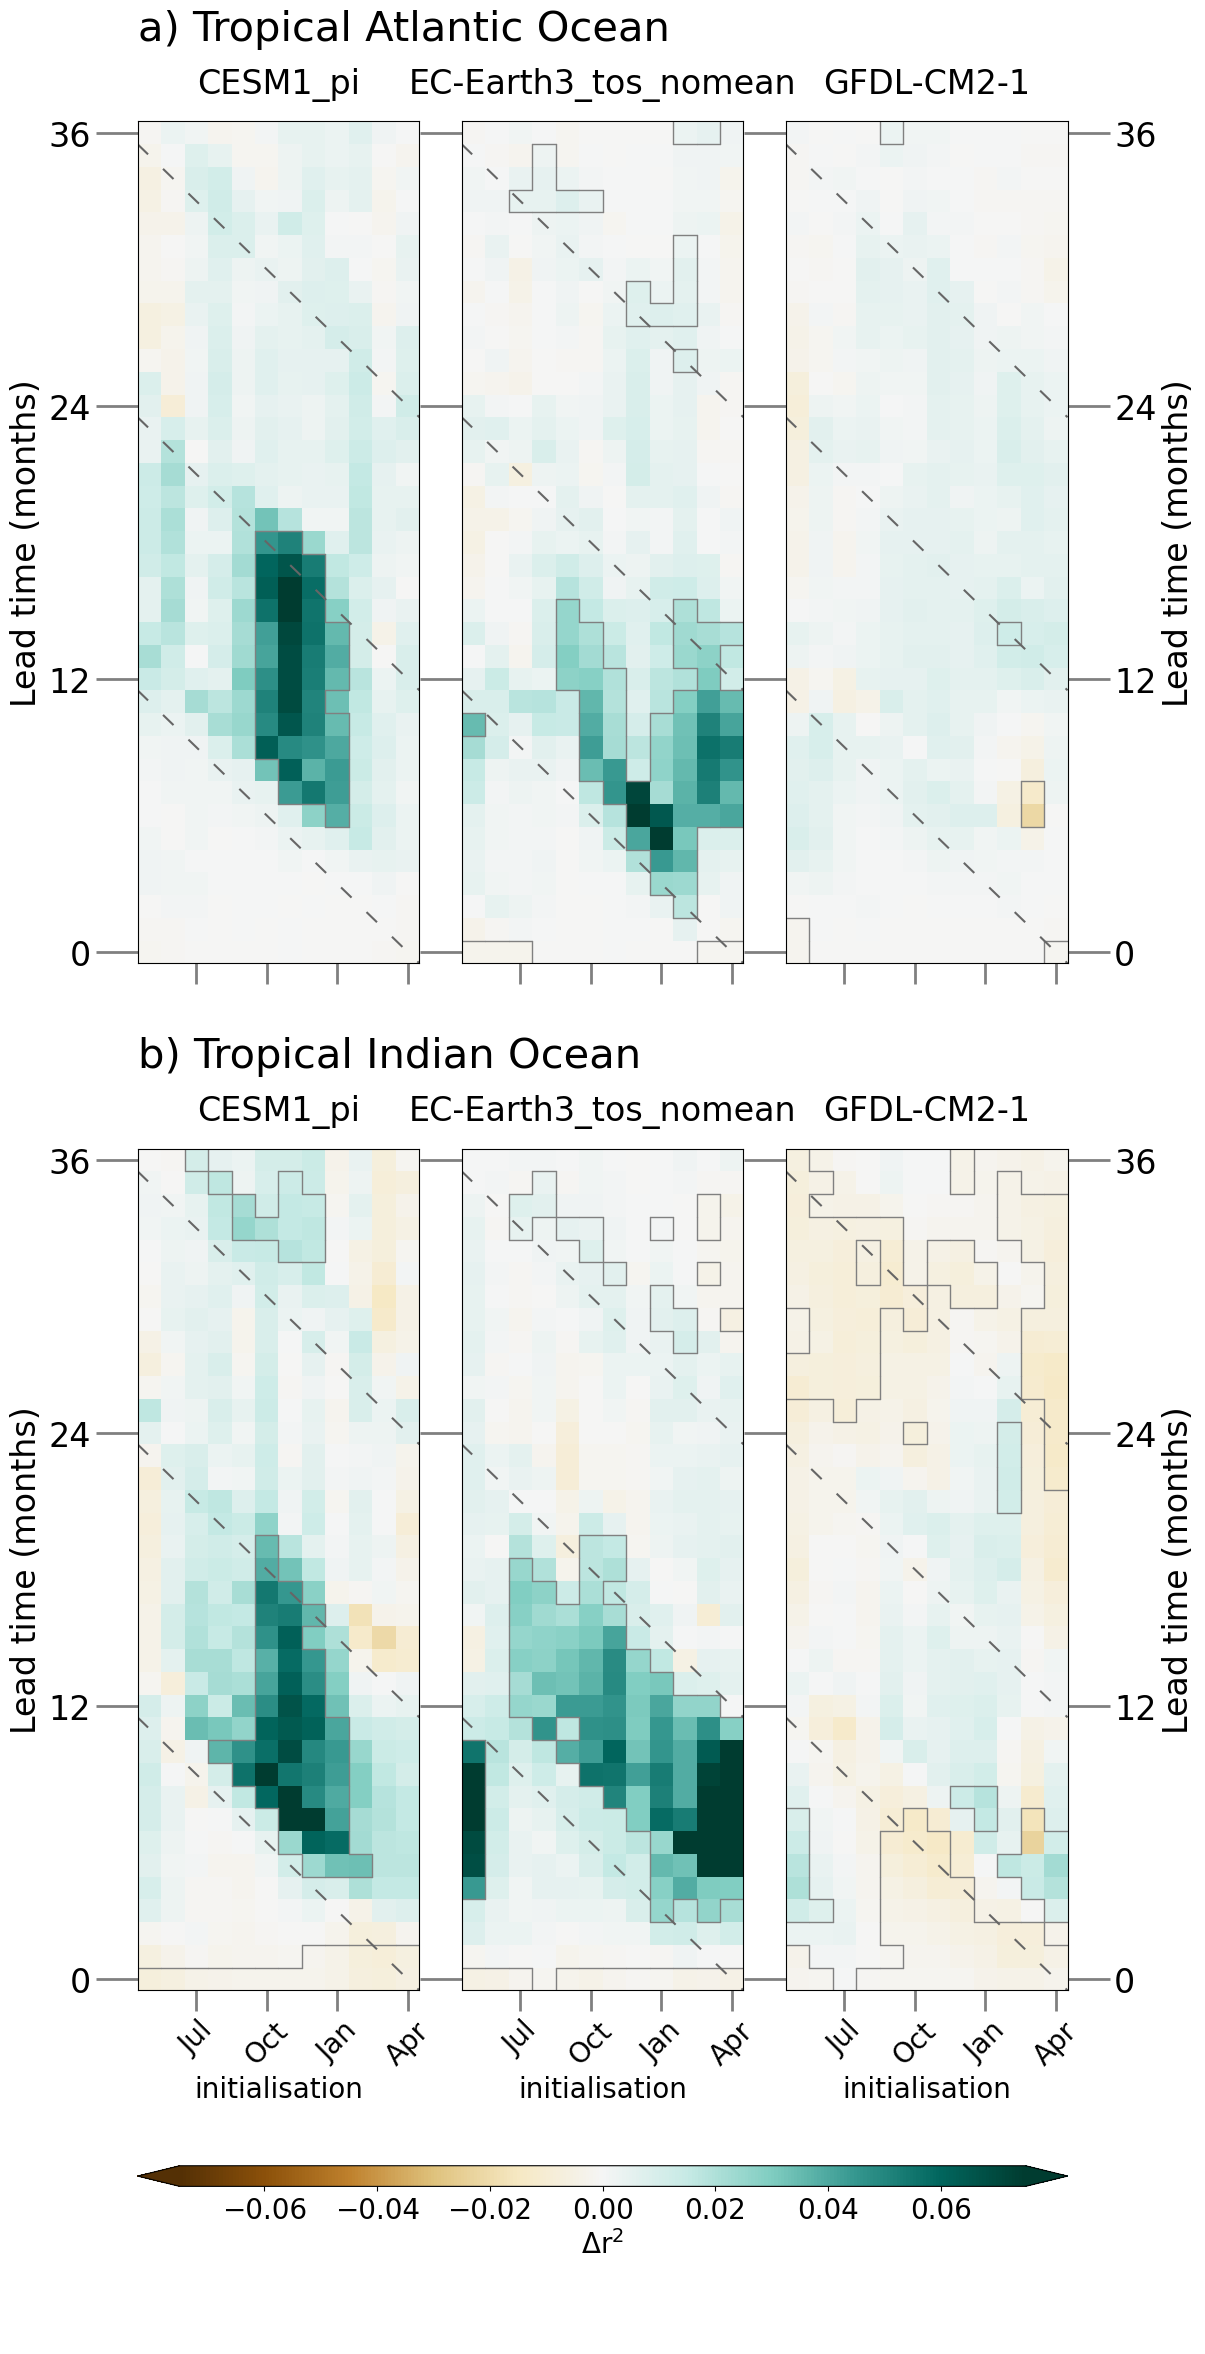

In [37]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/pacemaker_'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I')]).load()
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P','10P'),
                     later_mask = ('10P30A','10P30I'),
                     models=models)
plt.subplots_adjust(hspace=0.3)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.025,"a) Tropical Atlantic Ocean",size=30,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.025,"b) Tropical Indian Ocean",size=30,ha='left',va='bottom')


plt.savefig('figures/area_corr_weight/pacemaker_10Ptropics.pdf')

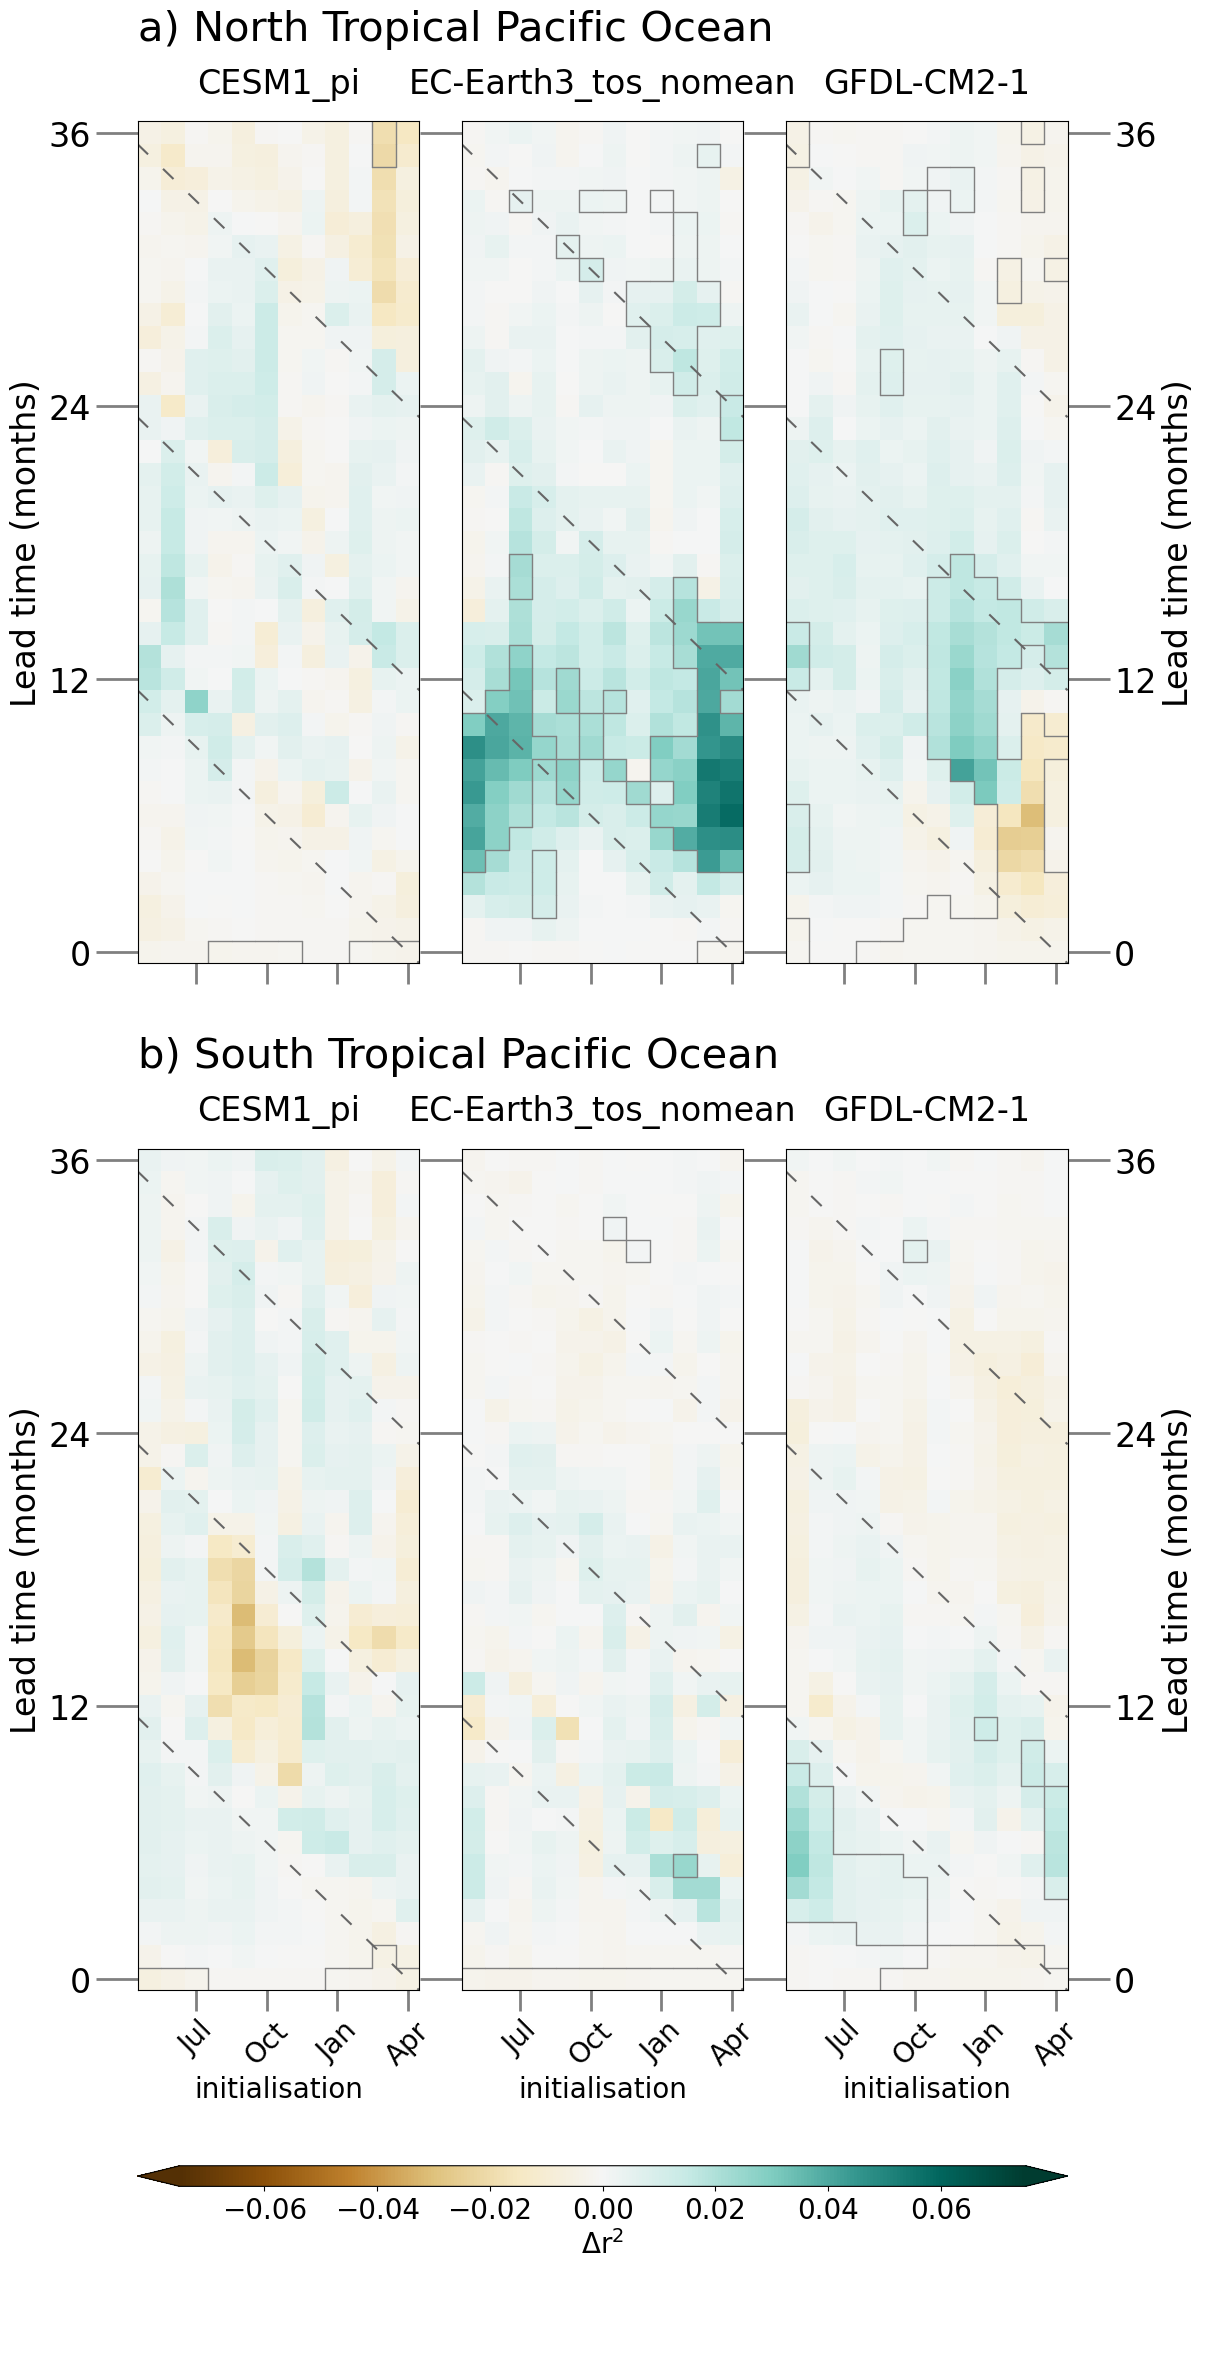

In [38]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/pacemaker_'+m+'.nc' 
                       for m in ('10P','10-30P','30-10P')]).load()
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P','10P'),
                     later_mask = ('10-30P','30-10P'),
                     models=models)
plt.subplots_adjust(hspace=0.3)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.025,"a) North Tropical Pacific Ocean",size=30,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.025,"b) South Tropical Pacific Ocean",size=30,ha='left',va='bottom')


plt.savefig('figures/area_corr_weight/pacemaker_pacific.pdf')

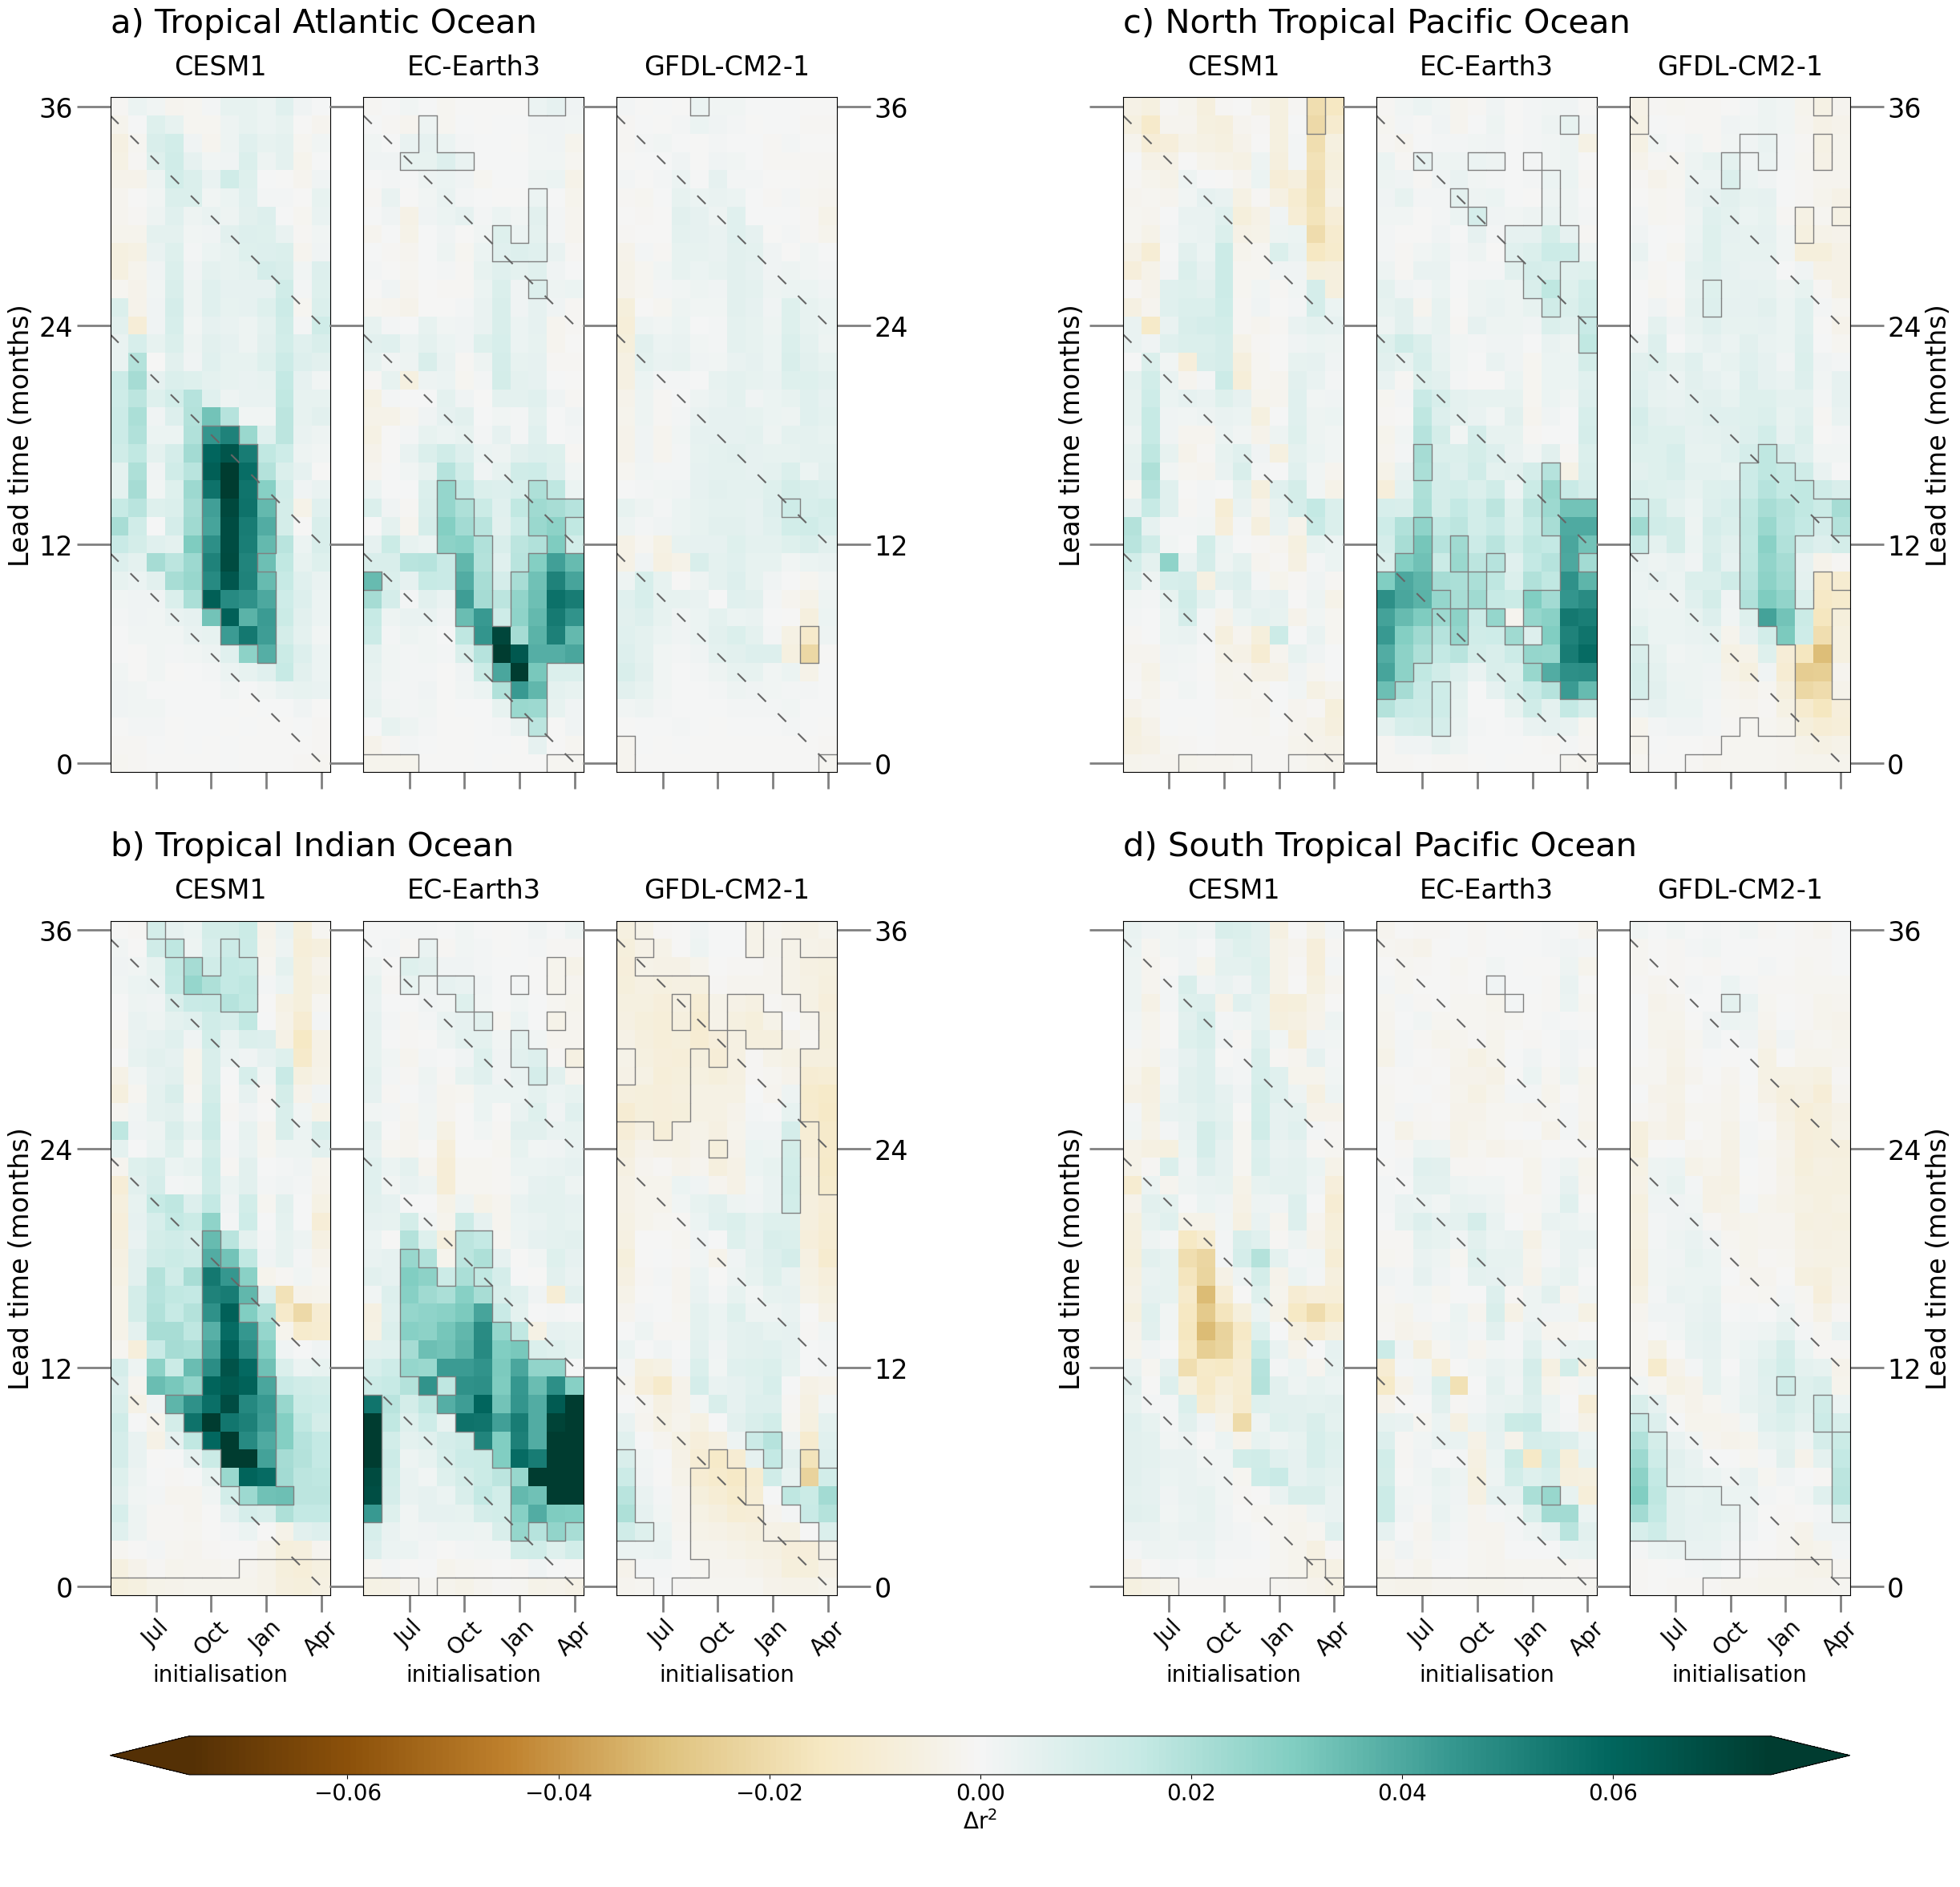

In [39]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/pacemaker_'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I','10-30P','30-10P')]).load()

#r = r.rename({'CESM1_pi':'CESM1','EC-Earth3_tos_nomean':'EC-Earth3'})

n = 7
start_mask = ['']*2
fig, axs = plt.subplots(len(start_mask)+1,7,figsize=(7*4,8.2*len(start_mask)*2.2*0.8),
                                sharey=True,gridspec_kw={'height_ratios':[1]*len(start_mask)+[0.2]} #sharex='col' #was hiding xticks
                               )
plot_bunch_of_models(r,
                     start_mask = ('10P','10P',),
                     later_mask = ('10-30P','30-10P'),
                     models=models,
                    fig = fig,
                    axs = axs[:,4:],
                    add_colorbar=False)

plot_bunch_of_models(r,
                     start_mask = ('10P','10P',),
                     later_mask = ('10P30A','10P30I'),
                     models=models,
                    fig = fig,
                    axs = axs)

for mi, m in enumerate(('CESM1','EC-Earth3','GFDL-CM2-1')):
    axs[0,0+mi].set_title(m,size=24,pad=20)
    axs[0,4+mi].set_title(m,size=24,pad=20)
    axs[1,0+mi].set_title(m,size=24,pad=20)
    axs[1,4+mi].set_title(m,size=24,pad=20)

plt.subplots_adjust(hspace=0.3)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.025,"a) Tropical Atlantic Ocean",size=30,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.025,"b) Tropical Indian Ocean",size=30,ha='left',va='bottom')
fig.text(axs[0,4].get_position().x0,axs[0,4].get_position().y1+0.025,"c) North Tropical Pacific Ocean",size=30,ha='left',va='bottom')
fig.text(axs[1,4].get_position().x0,axs[1,4].get_position().y1+0.025,"d) South Tropical Pacific Ocean",size=30,ha='left',va='bottom')

for mi in range(2):
    axs[mi,4].set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)
    axs[mi,2].tick_params(right=True,labelright=True)
    axs[mi,2].set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)

[axs[i,3].axis('off') for i in range(3)]

plt.savefig('figures/area_corr_weight/pacemaker_everything.pdf',bbox_inches='tight',pad_inches=0.4)

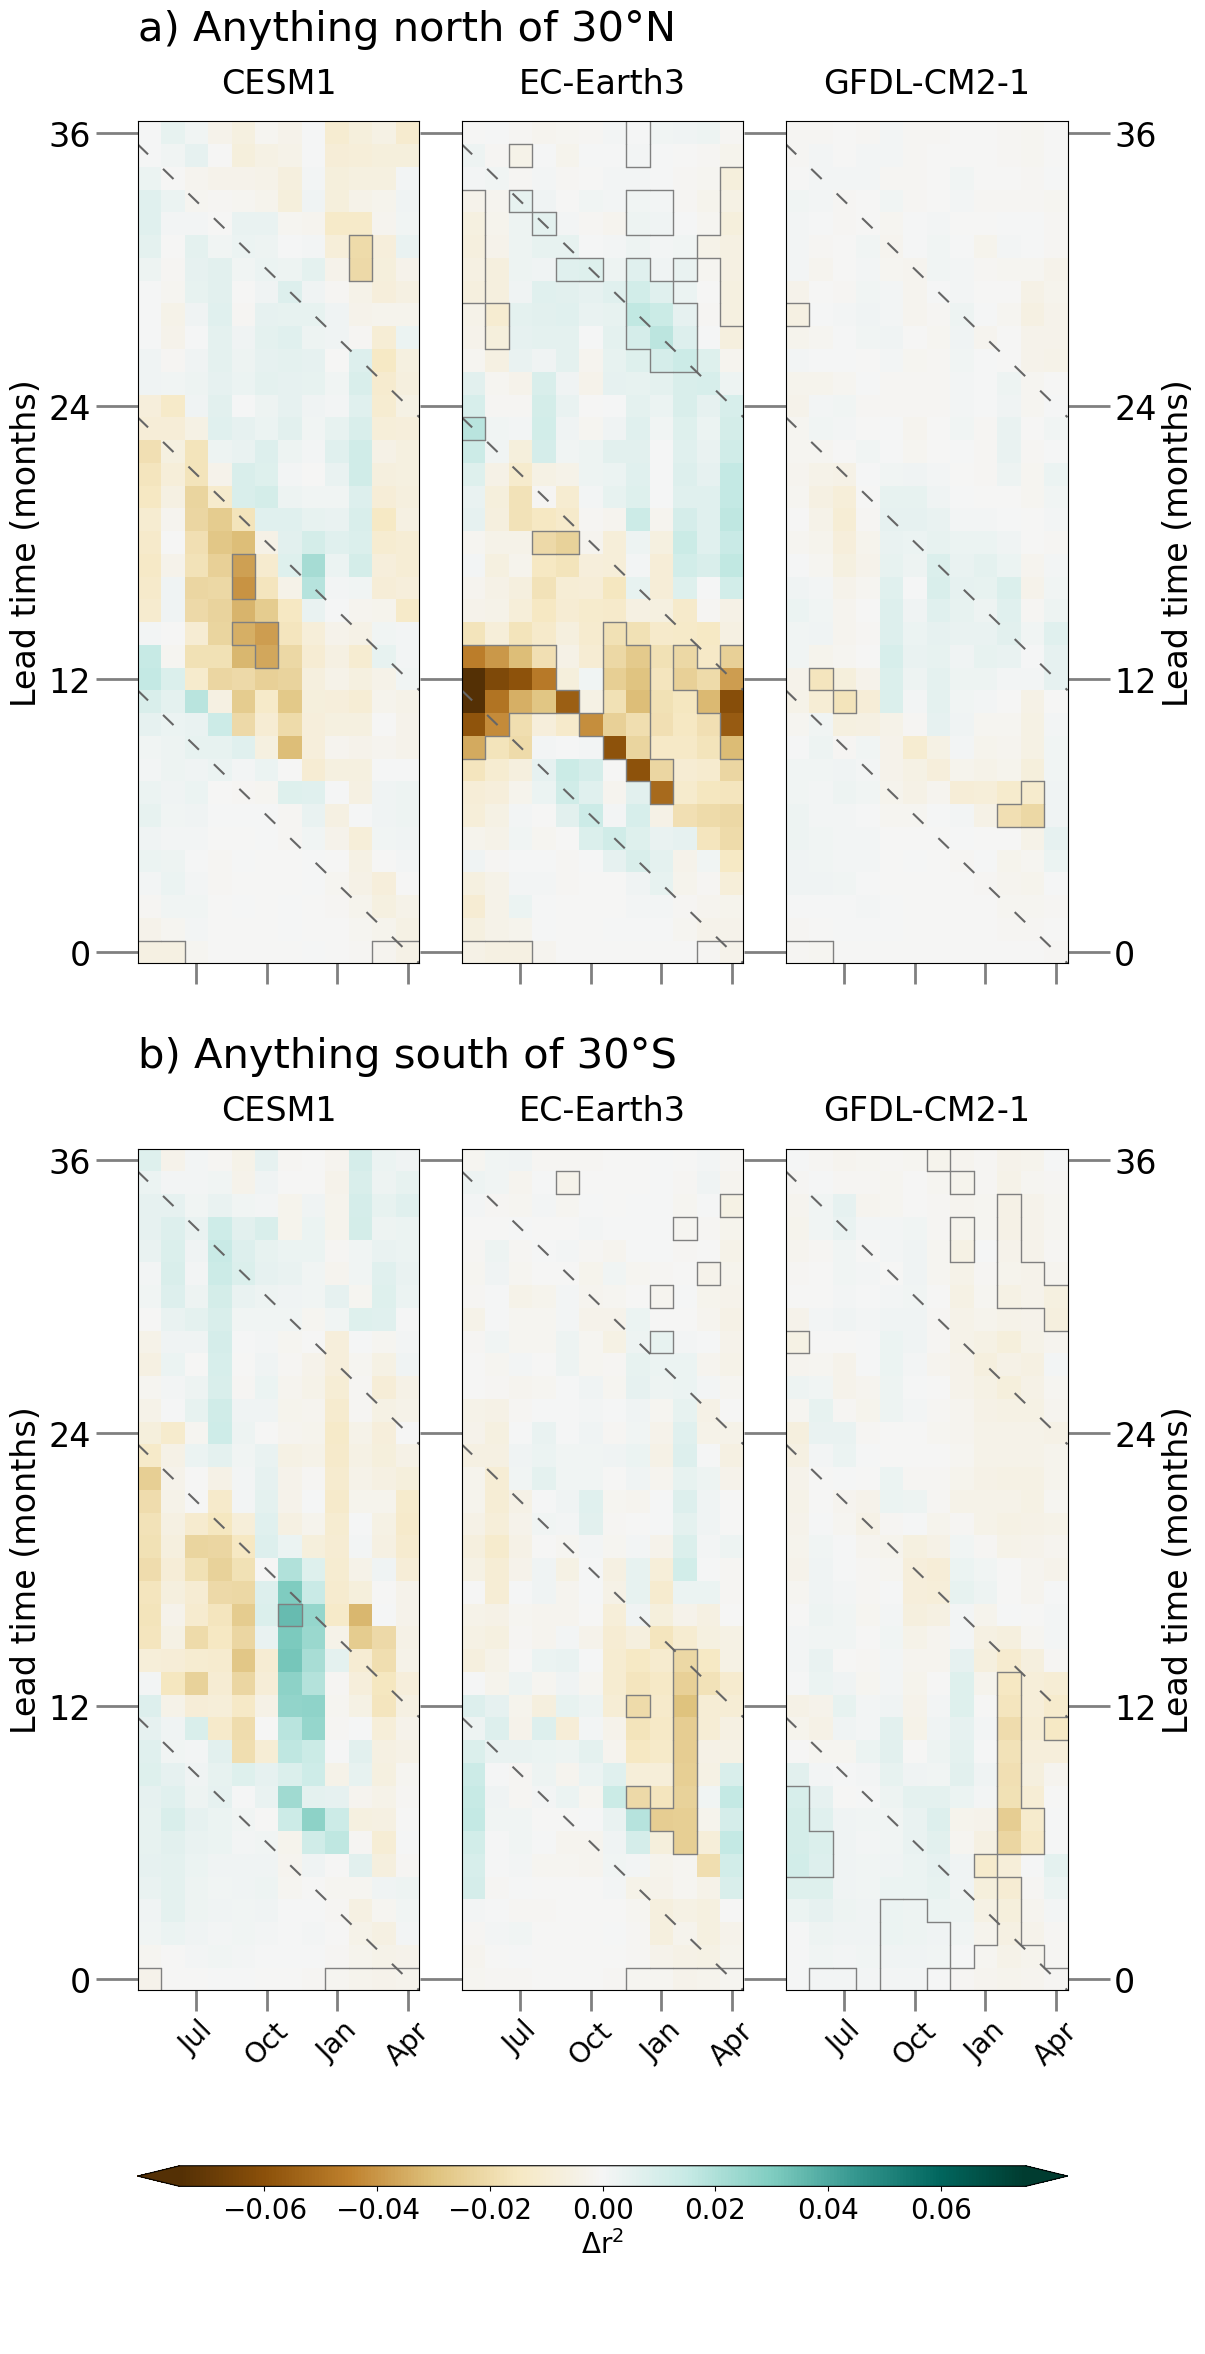

In [34]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/pacemaker_'+m+'.nc' 
                       for m in ('10P','10P30N','10P30S')]).load()
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P','10P'),
                     later_mask = ('10P30N','10P30S'),
                     models=models)
plt.subplots_adjust(hspace=0.3)
for mi, m in enumerate(('CESM1','EC-Earth3','GFDL-CM2-1')):
    axs[0,0+mi].set_title(m,size=24,pad=20)
    axs[1,0+mi].set_title(m,size=24,pad=20)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.025,"a) Anything north of 30°N",size=30,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.025,"b) Anything south of 30°S",size=30,ha='left',va='bottom')
plt.savefig('figures/area_corr_weight/pacemaker_poles.pdf',bbox_inches='tight',pad_inches=0.4)